In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
import numpy as np
import math
from functools import partial
import torch
import torch.nn as nn

import ipywidgets as widgets
import io
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

import warnings
warnings.filterwarnings("ignore")
def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)


def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.


def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    # work with diff dim tensors, not just 2D ConvNets
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + \
        torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C //
                                  self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(
            drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class VisionTransformer(nn.Module):
    """
    Vision Transformer
    """

    def __init__(self, img_size=[224], patch_size=16, in_chans=3, num_classes=0, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = PatchEmbed(
            img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = nn.Linear(
            embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def interpolate_pos_encoding(self, x, w, h):
        npatch = x.shape[1] - 1
        N = self.pos_embed.shape[1] - 1
        if npatch == N and w == h:
            return self.pos_embed
        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        w0, h0 = w0 + 0.1, h0 + 0.1
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(
                math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode='bicubic',
        )
        assert int(
            w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    def prepare_tokens(self, x):
        B, nc, w, h = x.shape
        x = self.patch_embed(x)  # patch linear embedding

        # add the [CLS] token to the embed patch tokens
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # add positional encoding to each token
        x = x + self.interpolate_pos_encoding(x, w, h)

        return self.pos_drop(x)

    def forward(self, x):
        x = self.prepare_tokens(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x[:, 0]

    def get_last_selfattention(self, x):
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            if i < len(self.blocks) - 1:
                x = blk(x)
            else:
                # return attention of the last block
                return blk(x, return_attention=True)

    def get_intermediate_layers(self, x, n=1):
        x = self.prepare_tokens(x)
        # we return the output tokens from the `n` last blocks
        output = []
        for i, blk in enumerate(self.blocks):
            x = blk(x)
            if len(self.blocks) - i <= n:
                output.append(self.norm(x))
        return output


class VitGenerator(object):
    def __init__(self, name_model, patch_size, device, evaluate=True, random=False, verbose=False):
        self.name_model = name_model
        self.patch_size = patch_size
        self.evaluate = evaluate
        self.device = device
        self.verbose = verbose
        self.model = self._getModel()
        self._initializeModel()
        if not random:
            self._loadPretrainedWeights()

    def _getModel(self):
        if self.verbose:
            print(
                f"[INFO] Initializing {self.name_model} with patch size of {self.patch_size}")
        if self.name_model == 'vit_tiny':
            model = VisionTransformer(patch_size=self.patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4,
                                      qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

        elif self.name_model == 'vit_small':
            model = VisionTransformer(patch_size=self.patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4,
                                      qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

        elif self.name_model == 'vit_base':
            model = VisionTransformer(patch_size=self.patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4,
                                      qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))
        else:
            raise f"No model found with {self.name_model}"

        return model

    def _initializeModel(self):
        if self.evaluate:
            for p in self.model.parameters():
                p.requires_grad = False

            self.model.eval()

        self.model.to(self.device)

    def _loadPretrainedWeights(self):
        if self.verbose:
            print("[INFO] Loading weights")
        url = None
        if self.name_model == 'vit_small' and self.patch_size == 16:
            url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"

        elif self.name_model == 'vit_small' and self.patch_size == 8:
            url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"

        elif self.name_model == 'vit_base' and self.patch_size == 16:
            url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"

        elif self.name_model == 'vit_base' and self.patch_size == 8:
            url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"

        elif self.name_model == 'vit_tiny' and self.patch_size == 16:
            url = "https://huggingface.co/WinKawaks/vit-tiny-patch16-224/resolve/main/pytorch_model.bin?download=true"

        if url is None:
            print(
                f"Since no pretrained weights have been found with name {self.name_model} and patch size {self.patch_size}, random weights will be used")

        else:
            state_dict = torch.hub.load_state_dict_from_url(#url)
                url="https://dl.fbaipublicfiles.com/dino/" + url)
            self.model.load_state_dict(state_dict, strict=True)

    def get_last_selfattention(self, img):
        return self.model.get_last_selfattention(img.to(self.device))

    def __call__(self, x):
        return self.model(x)
def transform(img, img_size):
    img = transforms.Resize(img_size)(img)
    img = transforms.ToTensor()(img)
    return img


def visualize_predict(model, img, img_size, patch_size, device):
    img_pre = transform(img, img_size)
    attention = visualize_attention(model, img_pre, patch_size, device)
    plot_attention(img, attention)


def visualize_attention(model, img, patch_size, device):
    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
        img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = model.get_last_selfattention(img.to(device))

    nh = attentions.shape[1]  # number of head

    # keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

    return attentions


def plot_attention(img, attention):
    n_heads = attention.shape[0]

    plt.figure(figsize=(10, 10))
    text = ["Original Image", "Head Mean"]
    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        plt.imshow(fig, cmap='inferno')
        plt.title(text[i])
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(n_heads):
        plt.subplot(n_heads//3, 3, i+1)
        plt.imshow(attention[i], cmap='inferno')
        plt.title(f"Head n: {i+1}")
    plt.tight_layout()
    plt.show()



class Loader(object):
    def __init__(self):
        self.uploader = widgets.FileUpload(accept='image/*', multiple=False)
        self._start()

    def _start(self):
        display(self.uploader)

    def getLastImage(self):
        try:
            for uploaded_filename in self.uploader.value:
                uploaded_filename = uploaded_filename
            img = Image.open(io.BytesIO(
                bytes(self.uploader.value[uploaded_filename]['content'])))

            return img
        except:
            return None

    def saveImage(self, path):
        with open(path, 'wb') as output_file:
            for uploaded_filename in self.uploader.value:
                content = self.uploader.value[uploaded_filename]['content']
                output_file.write(content)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if device.type == "cuda":
    torch.cuda.set_device(0)

# name_model = 'vit_small'
# patch_size = 8

# model = VitGenerator(name_model, patch_size,
#                      device, evaluate=True, random=False, verbose=True)

# ! wget "https://github.com/aryan-jadon/Medium-Articles-Notebooks/raw/main/Visualizing%20Attention%20in%20Vision%20Transformer/corgi_image.jpg"
# ! wget "https://github.com/aryan-jadon/Medium-Articles-Notebooks/raw/main/Visualizing%20Attention%20in%20Vision%20Transformer/orange_cat.jpg"


# # Visualizing Dog Image
# path = '/content/orange_cat.jpg'
# img = Image.open(path)
# factor_reduce = 2
# img_size = tuple(np.array(img.size[::-1]) // factor_reduce)
# visualize_predict(model, img, img_size, patch_size, device)

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import glob
from PIL import Image
from itertools import chain

from tqdm.notebook import tqdm
from __future__ import print_function

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset


In [ ]:
import pickle

In [ ]:
# rm -rf /content/data

In [ ]:
#to unzip the datasets
import zipfile
#sklearn to split the data

from sklearn.model_selection import train_test_split

In [ ]:
#Load data
os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'

In [ ]:
# #Unzipping dataset
os.makedirs('data', exist_ok=True)

with zipfile.ZipFile('/content/drive/MyDrive/ODL/new_train1.zip') as train_zip:
    train_zip.extractall(train_dir)

# with zipfile.ZipFile('/content/drive/MyDrive/ODL/test.zip') as test_zip:
#     test_zip.extractall('data')

In [ ]:
#Creating train and test list

train_list = glob.glob(os.path.join('/content/data/train','*.jpg'))
# test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
#printing length of the dataset

print(f"Train Data: {len(train_list)}")
# print(f"Test Data: {len(test_list)}")

Train Data: 26029


In [ ]:
print(f"Train Data: {len(train_list)}")


Train Data: 26029


In [ ]:
train_list= list(new_elements_set)

In [ ]:
train_set = set(train_list)
old_train_set = set(old_train_list)

# Find the elements in train_set that are not in old_train_set
new_elements_set = train_set - new_elements_set

# Calculate the length of new_elements_set
num_new_elements = len(new_elements_set)

In [ ]:
# valid_list = list(new_elements_set)
# labels = [path.split('/')[-1].split('.')[0] for path in valid_list]
# valid_list, test_list = train_test_split(valid_list,
#                                           test_size=0.75,
#                                           stratify=labels)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 5000
Validation Data: 5227
Test Data: 15682


In [ ]:
#Defining labels

labels = [path for path in train_list]



In [ ]:
labels


In [ ]:
#Splitting train and validation list
seed = 42
train_list, valid_list = train_test_split(train_list,
                                          test_size=0.8,
                                          stratify=labels)

labels = [path.split('/')[-1].split('.')[0] for path in valid_list]
valid_list, test_list = train_test_split(valid_list,
                                          test_size=0.75,
                                          stratify=labels)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 5000
Validation Data: 5000
Test Data: 15000


In [ ]:
# Save the lists


#****DONT RUN
with open('/content/drive/MyDrive/ODL/data_apr21_cleaned.pkl', 'wb') as f:
    pickle.dump([train_list, valid_list, test_list], f)


In [ ]:

# Load the lists
with open('drive/MyDrive/ODL/data_apr21_cleaned.pkl', 'rb') as f:
    old_train_list, valid_list, test_list = pickle.load(f)

# Print the lengths of the lists
print(f"Train Data: {len(old_train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 5120
Validation Data: 5227
Test Data: 15682


In [ ]:
# Torch transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [ ]:
#Loading dataset for training

class CatsDogsDataset1(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split("_")[1]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [ ]:
#Loading dataset for training

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img = img.convert("RGB")
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [ ]:
#defining train, validation and test dataset

train_data = CatsDogsDataset(old_train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [ ]:
# for i in range(len(train_data)):

#   try:
#     if train_data[i][0].shape!= torch.Size([3, 224, 224]):
#       print(i, train_data[i][0].shape)
#       train_data.file_list.remove(train_data.file_list[i])
#   except:
#     print(i)
#     train_data.file_list.remove(train_data.file_list[i])

In [ ]:
model =0

In [ ]:
torch.save(model, '/content/drive/MyDrive/ODL/apr22_best_model.pth')

In [ ]:
batch_size = 32

In [ ]:
#loading dataloader

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained VIT model
name_model = 'vit_small'
patch_size = 8
model = VitGenerator(name_model, patch_size, device, evaluate=False, random=False, verbose=True)


# Replace the classifier head with a new one
num_classes = 2  # Cats vs Dogs
model.model.head = nn.Linear(model.model.embed_dim, num_classes)

# Move the model to the device
model.model = model.model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.model.head.parameters(), lr=0.001)

i = 0
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model.model.head(model.model(inputs))
        # print(outputs.shape, "shape")
        # print(labels.shape)
        # print(outputs)
        # print(labels)
        # break
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        i += 1
        # if i==10:
        #   break
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    # Evaluate on the validation set
    model.model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i,(inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.model.head(model.model(inputs))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')
    model.model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i,(inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model.model.head(model.model(inputs))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Train Accuracy: {accuracy:.2f}%')
    model.model.train()
print('Finished Training')

[INFO] Initializing vit_small with patch size of 8
[INFO] Loading weights


100%|██████████| 160/160 [04:32<00:00,  1.71s/it]

Epoch 1/10, Loss: 0.0952


Validation Accuracy: 98.59%
Train Accuracy: 98.98%


100%|██████████| 160/160 [04:33<00:00,  1.71s/it]

Epoch 2/10, Loss: 0.0274


Validation Accuracy: 98.82%
Train Accuracy: 99.49%


100%|██████████| 160/160 [04:33<00:00,  1.71s/it]

Epoch 3/10, Loss: 0.0190


Validation Accuracy: 98.91%
Train Accuracy: 99.57%


100%|██████████| 160/160 [04:33<00:00,  1.71s/it]

Epoch 4/10, Loss: 0.0138


Validation Accuracy: 98.90%
Train Accuracy: 99.77%


100%|██████████| 160/160 [04:33<00:00,  1.71s/it]

Epoch 5/10, Loss: 0.0114


Validation Accuracy: 98.82%
Train Accuracy: 99.84%


100%|██████████| 160/160 [04:33<00:00,  1.71s/it]

Epoch 6/10, Loss: 0.0088


Validation Accuracy: 98.84%


KeyboardInterrupt: 

In [ ]:
model.model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model.model.head(model.model(inputs))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total


In [ ]:
pip install peft

In [ ]:
model = torch.load('/content/drive/MyDrive/ODL/vit_generator_model_apr19_1950_cleansplit.pth')

In [ ]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from peft import get_peft_model, LoraConfig, TaskType

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained VIT model
name_model = 'vit_small'
patch_size = 8
model = VitGenerator(name_model, patch_size, device, evaluate=False, random=False, verbose=True)

# Replace the classifier head with a new one
num_classes = 2  # Cats vs Dogs
model.model.head = nn.Linear(model.model.embed_dim, num_classes)

# Move the model to the device
model.model = model.model.to(device)

# Create a PEFT configuration
peft_config = LoraConfig(
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=['head', 'patch_embed.proj', 'qkv', 'proj']
)

# Wrap the model with PEFT
model.model = get_peft_model(model.model, peft_config)

[INFO] Initializing vit_small with patch size of 8
[INFO] Loading weights


In [ ]:
print_trainable_parameters(model.model)

trainable params: 228880 || all params: 21899922 || trainable%: 1.05


In [ ]:

# Move the model to the device
model.model = model.model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.model.head.parameters(), lr=0.001)

i = 0
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model.model.head(model.model(inputs))
        # print(outputs.shape, "shape")
        # print(labels.shape)
        # print(outputs)
        # print(labels)
        # break
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        i += 1
        # if i==10:
        #   break

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Evaluate on the validation set
    model.model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i,(inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model.model.head(model.model(inputs))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')

    model.model.train()

print('Finished Training')

100%|██████████| 16/16 [00:29<00:00,  1.82s/it]


Epoch 1/5, Loss: 0.1135
Validation Accuracy: 99.20%


100%|██████████| 16/16 [00:27<00:00,  1.74s/it]


Epoch 2/5, Loss: 0.0681
Validation Accuracy: 99.08%


100%|██████████| 16/16 [00:27<00:00,  1.75s/it]


Epoch 3/5, Loss: 0.0421
Validation Accuracy: 98.98%


100%|██████████| 16/16 [00:28<00:00,  1.75s/it]


Epoch 4/5, Loss: 0.0283


KeyboardInterrupt: 

In [ ]:
del model

Test Accuracy: 98.14%
Correct: 5130 Incorrect: 97


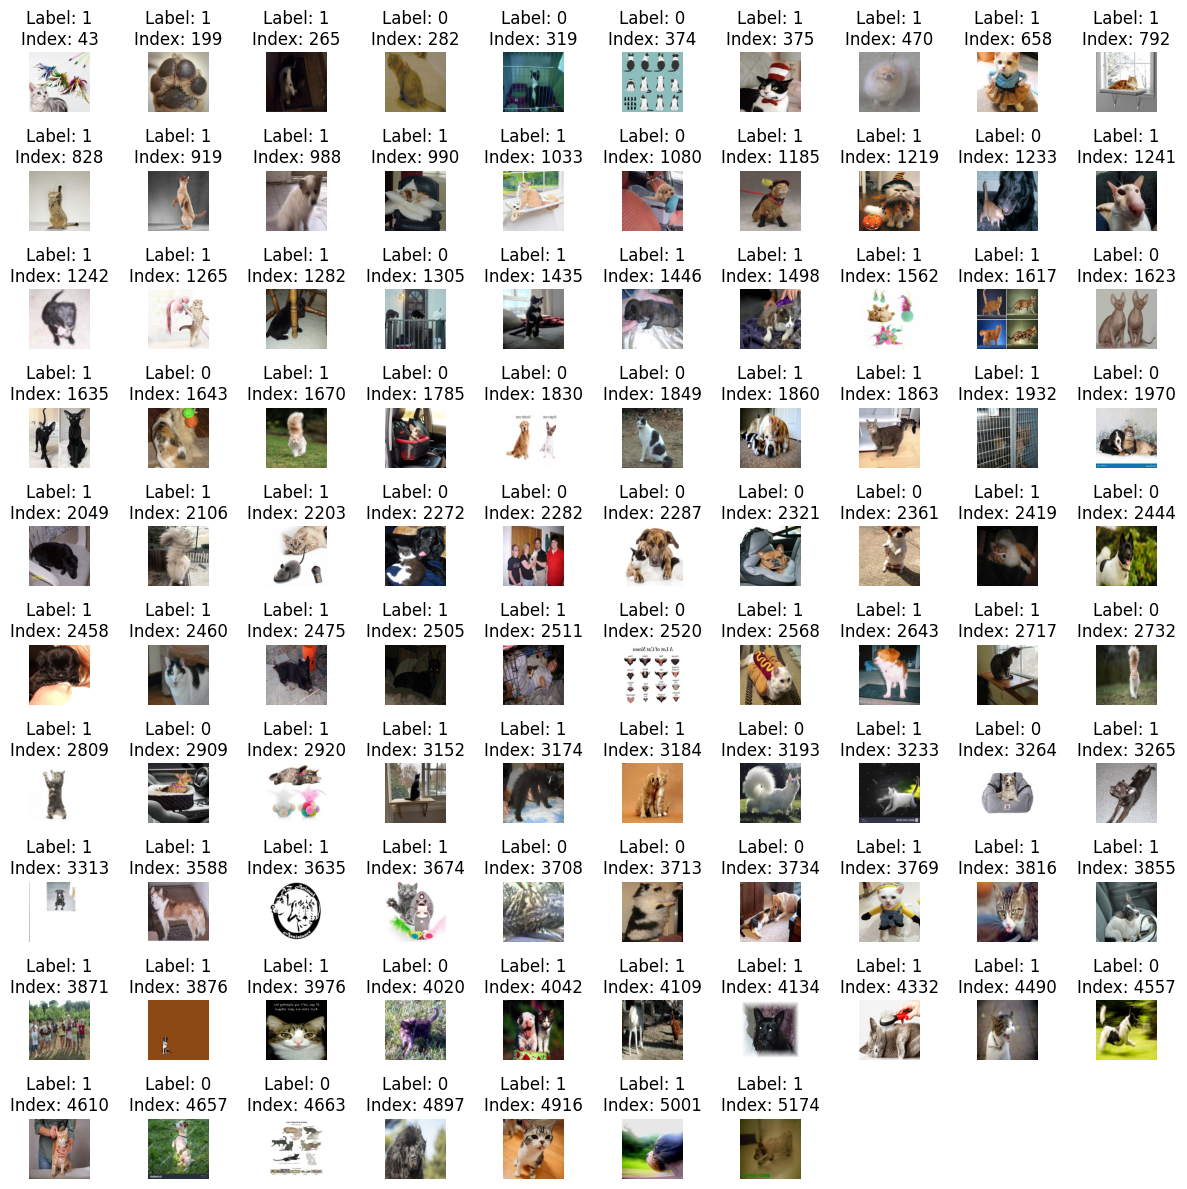

In [ ]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np

# model.model.eval()
# correct = 0
# total = 0
# wrong_images = []
# wrong_labels = []
# wrong_indices = []
# wrong_counter = 0

# with torch.no_grad():
#     for i, (inputs, labels) in enumerate(valid_loader):
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         # print(labels,i)
#         outputs = model.model.head(model.model(inputs))
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         wrong_mask = (predicted != labels)
#         wrong_images.extend(inputs[wrong_mask].cpu().numpy())
#         wrong_labels.extend(labels[wrong_mask].cpu().numpy())
#         wrong_indices.extend([i * train_loader.batch_size + j for j in range(len(inputs)) if wrong_mask[j]])
#         wrong_counter += wrong_mask.sum().item()
#         # if wrong_counter >= 64:
#         #     break

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')
print('Correct:',correct, 'Incorrect:', total-correct)

# Plot the first 64 wrong images in an 8x8 grid
fig, axes = plt.subplots(10,10, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < len(wrong_images):
        ax.imshow(np.transpose(wrong_images[i], (1, 2, 0)))
        ax.set_title(f"Label: {int(wrong_labels[i])}\nIndex: {wrong_indices[i]}")
        ax.axis('off')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
x = [valid_list[wrong_indices[i]] for i in range(len(wrong_indices))]

In [ ]:
y = x[1:6]+x[1:6]+x[7:8]+x[12:14]+x[20:21]+x[22:23]+x[25:26]+x[29:30]+x[35:36]+x[38:39] +x[40:41]+x[50:51]+x[70:71] + x[66:67]+ x[96:98]

In [ ]:
len(y)

24

In [ ]:
# Plot the first 64 wrong images in an 8x8 grid
fig, axes = plt.subplots(10,10, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < len(wrong_images):
        ax.imshow(np.transpose(wrong_images[i], (1, 2, 0)))
        ax.set_title(f"Label: {int(wrong_labels[i])}\nIndex: {wrong_indices[i]}")
        ax.axis('off')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import pickle

# Load data from "wrongly_classified.txt"
x = y
# with open("/content/drive/MyDrive/ODL/wrongly_classified.txt", "r") as file:
#     for line in file:
#         x.append(line.strip())

# Save the list as a pickle file
with open("wrongly_classified.pkl", "wb") as file:
    pickle.dump(x, file)

# Load the pickle file
with open("wrongly_classified.pkl", "rb") as file:
    x_loaded = pickle.load(file)

# Print the loaded list
print(x_loaded)


['/content/data/train/dog.31910.jpg', '/content/data/train/dog.30514.jpg', '/content/data/train/cat.10145.jpg', '/content/data/train/cat.2948.jpg', '/content/data/train/cat.31407.jpg', '/content/data/train/dog.31910.jpg', '/content/data/train/dog.30514.jpg', '/content/data/train/cat.10145.jpg', '/content/data/train/cat.2948.jpg', '/content/data/train/cat.31407.jpg', '/content/data/train/dog.1745.jpg', '/content/data/train/dog.2647.jpg', '/content/data/train/dog.6835.jpg', '/content/data/train/dog.11465.jpg', '/content/data/train/dog.11300.jpg', '/content/data/train/dog.10939.jpg', '/content/data/train/cat.3300.jpg', '/content/data/train/cat.709.jpg', '/content/data/train/dog.2099.jpg', '/content/data/train/dog.7553.jpg', '/content/data/train/dog.6680.jpg', '/content/data/train/dog.3994.jpg', '/content/data/train/cat.30306.jpg', '/content/data/train/dog.7265.jpg']


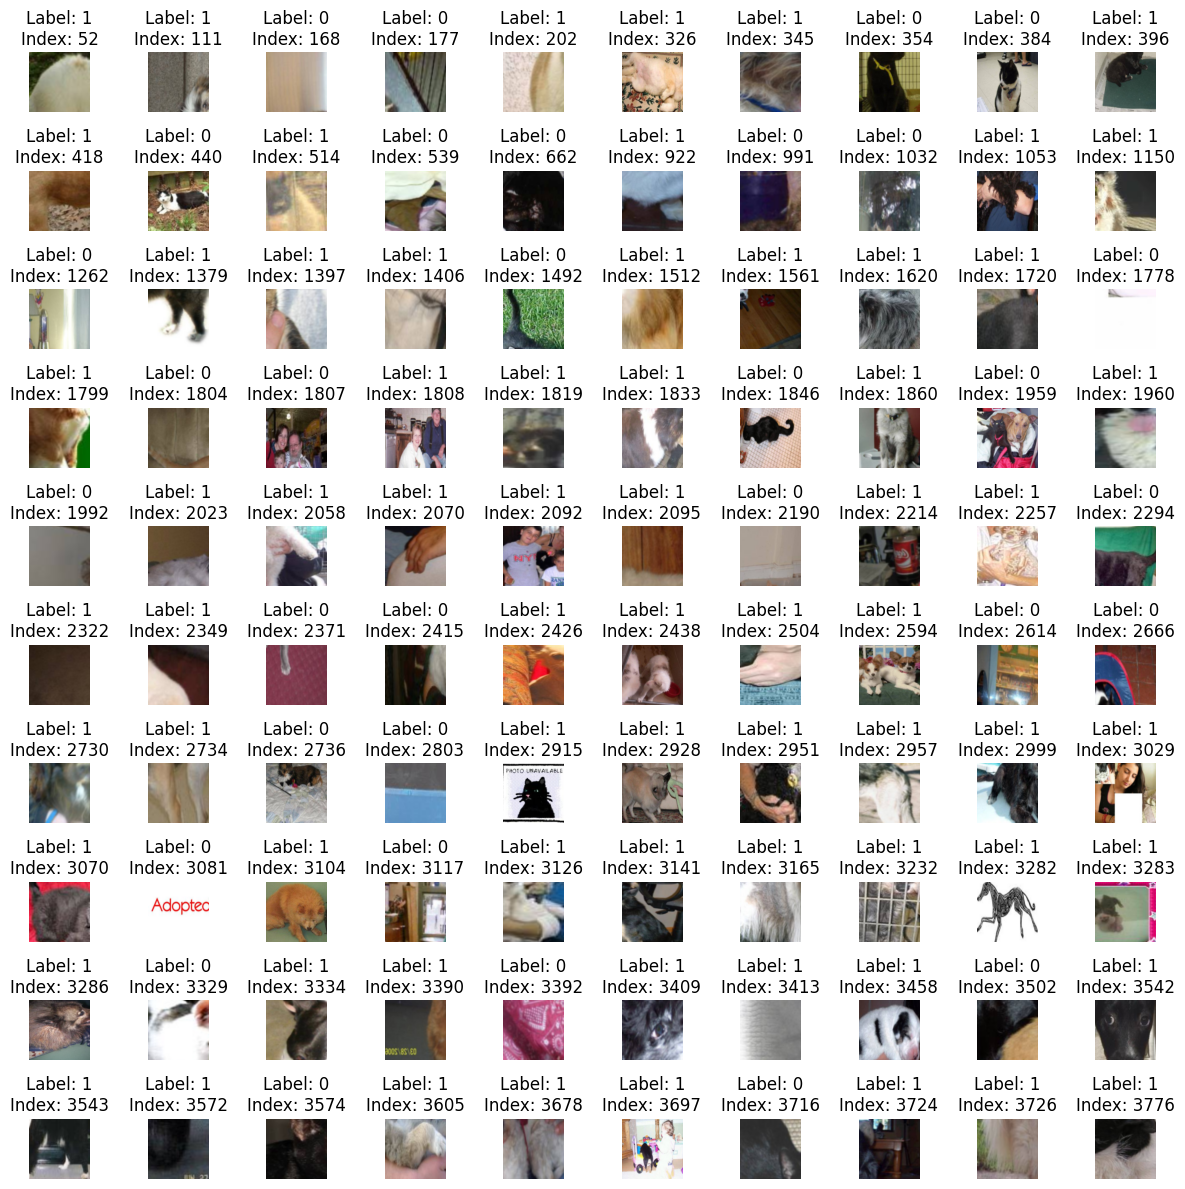

In [ ]:
# Plot the first 64 wrong images in an 8x8 grid
fig, axes = plt.subplots(10, 10, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < len(wrong_images):
        ax.imshow(np.transpose(wrong_images[i], (1, 2, 0)))
        ax.set_title(f"Label: {int(wrong_labels[i])}\nIndex: {wrong_indices[i]}")
        ax.axis('off')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

(train_data), info = tfds.load('cats_vs_dogs', split=['train'], with_info=True)

In [ ]:
import pickle

In [ ]:
with open("wrongly_classified.pkl", "wb") as file:
    pickle.dump(y, file)

NameError: name 'x' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Resize, ToTensor
import tensorflow_datasets as tfds

# Load the dataset
ds, info = tfds.load('cats_vs_dogs', split='train', with_info=True)
train_data = next(iter(ds))

# Define the transforms
transform = transforms.Compose([
    Resize((224, 224)),
    ToTensor()
])

# Create the PyTorch dataset
class CatsVsDogs(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data['image'])

    def __getitem__(self, idx):
        image = self.data['image'][idx]
        label = self.data['label'][idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = CatsVsDogs(train_data, transform=transform)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Resize, ToTensor
import tensorflow_datasets as tfds

# Load the dataset
(train_data, ), info = tfds.load('cats_vs_dogs', split=['train'], with_info=True)

# Define the transforms
transform = transforms.Compose([
    Resize((224, 224)),
    ToTensor()
])

# Create the PyTorch dataset
class CatsVsDogs(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        label = self.data[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = CatsVsDogs(train_data, transform=transform)

In [ ]:
train_dataset

{'image': <tf.Tensor: shape=(262, 350, 3), dtype=uint8, numpy=
 array([[[251, 255, 255],
         [248, 254, 252],
         [242, 246, 245],
         ...,
         [188, 176, 128],
         [142, 132,  81],
         [160, 150,  99]],
 
        [[247, 253, 251],
         [246, 252, 250],
         [241, 245, 244],
         ...,
         [188, 178, 129],
         [164, 154, 103],
         [176, 166, 115]],
 
        [[244, 249, 245],
         [244, 249, 245],
         [236, 241, 237],
         ...,
         [197, 187, 138],
         [203, 193, 142],
         [198, 191, 139]],
 
        ...,
 
        [[127, 124,  73],
         [149, 146,  95],
         [155, 152, 101],
         ...,
         [165, 170, 140],
         [ 81,  88,  57],
         [ 75,  84,  53]],
 
        [[167, 164, 113],
         [104, 101,  50],
         [139, 136,  85],
         ...,
         [ 67,  73,  45],
         [ 48,  57,  28],
         [ 38,  49,  19]],
 
        [[135, 132,  81],
         [ 77,  74,  23],
     

In [ ]:
rm -r PetImages/

In [ ]:
import os
import tensorflow_datasets as tfds

# Load the dataset
ds, info = tfds.load('cats_vs_dogs', split='train', with_info=True)

# Specify the base save path
base_save_path = 'PetImages'
os.makedirs(base_save_path, exist_ok=True)

# Save the images
for data in ds:
    image = data['image'].numpy()
    label = data['label']
    filename = data['image/filename'].numpy().decode('utf-8')
    filename_parts = filename.split('/')
    save_dir = os.path.join(base_save_path, filename_parts[-2])
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, filename_parts[-1])

    # Save the image
    Image.fromarray(image).save(save_path)

    print(f"Saved image {save_path} with label {label}")

Streaming output truncated to the last 5000 lines.
Saved image PetImages/Dog/9394.jpg with label 1
Saved image PetImages/Dog/4831.jpg with label 1
Saved image PetImages/Cat/8481.jpg with label 0
Saved image PetImages/Dog/3266.jpg with label 1
Saved image PetImages/Dog/8154.jpg with label 1
Saved image PetImages/Cat/2921.jpg with label 0
Saved image PetImages/Cat/5419.jpg with label 0
Saved image PetImages/Cat/10774.jpg with label 0
Saved image PetImages/Dog/9159.jpg with label 1
Saved image PetImages/Cat/5337.jpg with label 0
Saved image PetImages/Dog/12153.jpg with label 1
Saved image PetImages/Dog/9779.jpg with label 1
Saved image PetImages/Cat/102.jpg with label 0
Saved image PetImages/Dog/1381.jpg with label 1
Saved image PetImages/Cat/3374.jpg with label 0
Saved image PetImages/Dog/8274.jpg with label 1
Saved image PetImages/Dog/1956.jpg with label 1
Saved image PetImages/Dog/12189.jpg with label 1
Saved image PetImages/Cat/5694.jpg with label 0
Saved image PetImages/Cat/5460.jpg 

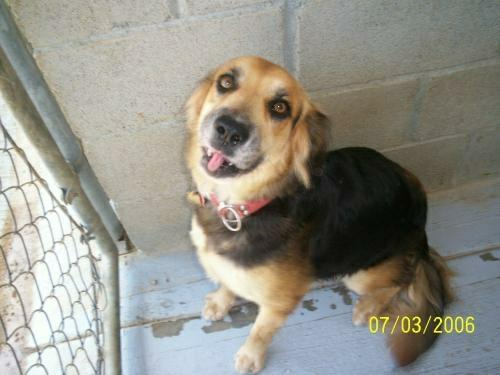

In [ ]:
from PIL import Image

# Open the image
image_path = "PetImages/Dog/6440.jpg"
image = Image.open(image_path)

# Display the image
image


In [ ]:
for data in ds:
    image = data['image'].numpy()
    print(image)
    break

[[[251 255 255]
  [248 254 252]
  [242 246 245]
  ...
  [188 176 128]
  [142 132  81]
  [160 150  99]]

 [[247 253 251]
  [246 252 250]
  [241 245 244]
  ...
  [188 178 129]
  [164 154 103]
  [176 166 115]]

 [[244 249 245]
  [244 249 245]
  [236 241 237]
  ...
  [197 187 138]
  [203 193 142]
  [198 191 139]]

 ...

 [[127 124  73]
  [149 146  95]
  [155 152 101]
  ...
  [165 170 140]
  [ 81  88  57]
  [ 75  84  53]]

 [[167 164 113]
  [104 101  50]
  [139 136  85]
  ...
  [ 67  73  45]
  [ 48  57  28]
  [ 38  49  19]]

 [[135 132  81]
  [ 77  74  23]
  [135 132  81]
  ...
  [ 61  70  41]
  [ 12  21   0]
  [ 64  75  45]]]


In [ ]:
# Torch transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [ ]:
#Loading dataset for training

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split("_")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [ ]:
import pickle

# Load data from "wrongly_classified.txt"
x = []
with open("/content/drive/MyDrive/ODL/wrongly_classified.txt", "r") as file:
    for line in file:
        x.append(line.strip())

# Save the list as a pickle file
with open("wrongly_classified.pkl", "wb") as file:
    pickle.dump(x, file)

with open("wrongly_classified.pkl", "rb") as file:
    x_loaded = pickle.load(file)

print(x_loaded)

['/content/data/train/dog.3953.jpg', '/content/data/train/dog.2789.jpg', '/content/data/train/cat.6970.jpg', '/content/data/train/cat.3859.jpg', '/content/data/train/dog.11309.jpg', '/content/data/train/dog.3773.jpg', '/content/data/train/dog.11163.jpg', '/content/data/train/cat.3397.jpg', '/content/data/train/cat.7059.jpg', '/content/data/train/dog.6694.jpg', '/content/data/train/dog.11234.jpg', '/content/data/train/cat.1507.jpg', '/content/data/train/dog.3396.jpg', '/content/data/train/cat.4429.jpg', '/content/data/train/cat.9685.jpg', '/content/data/train/dog.8138.jpg', '/content/data/train/cat.4182.jpg', '/content/data/train/cat.6218.jpg', '/content/data/train/dog.10191.jpg', '/content/data/train/dog.5807.jpg', '/content/data/train/cat.8928.jpg', '/content/data/train/dog.3530.jpg', '/content/data/train/dog.3896.jpg', '/content/data/train/dog.675.jpg', '/content/data/train/cat.11793.jpg', '/content/data/train/dog.4201.jpg', '/content/data/train/dog.11604.jpg', '/content/data/train/d

In [ ]:
x_loaded = train_list

In [ ]:
train_data = CatsDogsDataset(x_loaded, transform=train_transforms)
batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained VIT model
name_model = 'vit_small'
patch_size = 8
model = VitGenerator(name_model, patch_size, device, evaluate=False, random=False, verbose=True)


# Replace the classifier head with a new one
num_classes = 2  # Cats vs Dogs
model.model.head = nn.Linear(model.model.embed_dim, num_classes)

# Move the model to the device
model.model = model.model.to(device)
model = torch.load('/content/drive/MyDrive/ODL/vit_generator_model_apr19_1950_cleansplit.pth')


[INFO] Initializing vit_small with patch size of 8
[INFO] Loading weights


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

model.model.eval()
correct = 0
total = 0
wrong_images = []
wrong_labels = []
wrong_indices = []
wrong_counter = 0

with torch.no_grad():
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels,i)
        outputs = model.model.head(model.model(inputs))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        wrong_mask = (predicted != labels)
        wrong_images.extend(inputs[wrong_mask].cpu().numpy())
        wrong_labels.extend(labels[wrong_mask].cpu().numpy())
        wrong_indices.extend([i * train_loader.batch_size + j for j in range(len(inputs)) if wrong_mask[j]])
        wrong_counter += wrong_mask.sum().item()
        # if wrong_counter >= 64:
        #     break

accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

# Plot the first 64 wrong images in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < len(wrong_images):
        ax.imshow(np.transpose(wrong_images[i], (1, 2, 0)))
        ax.set_title(f"Label: {int(wrong_labels[i])}\nIndex: {wrong_indices[i]}")
        ax.axis('off')
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 277, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 144, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 144, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 121, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 173, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


In [ ]:
x = [x_loaded[wrong_indices[i]] for i in range(len(wrong_indices))]

In [ ]:
pip install imagenet_simple_api

ERROR: Could not find a version that satisfies the requirement imagenet_simple_api (from versions: none)
ERROR: No matching distribution found for imagenet_simple_api


In [ ]:
import tarfile
import os
import shutil
import urllib.request

# # Function to extract images from tar.gz files
def extract_images(tar_file_path, extract_dir):
    with tarfile.open(tar_file_path, 'r:gz') as tar:
        tar.extractall(path=extract_dir)

# # Function to move images and rename based on synset IDs
def move_and_rename_images(image_dir, synset_ids, category):
    # Move images and rename
    for synset_id in synset_ids:
        synset_dir = f'{image_dir}/{synset_id}'
        if os.path.exists(synset_dir):
            for i, filename in enumerate(os.listdir(synset_dir)):
                shutil.move(f'{synset_dir}/{filename}', f'train/{category}/{category}_{i+1}.jpg')

# # URLs to the downloaded tar.gz files
# test_images_url = 'https://huggingface.co/datasets/imagenet-1k/resolve/main/data/test_images.tar.gz?download=true'
# val_images_url = 'https://huggingface.co/datasets/imagenet-1k/resolve/main/data/val_images.tar.gz?download=true'

# # Download tar.gz files
# urllib.request.urlretrieve(test_images_url, 'test_images.tar.gz')
# urllib.request.urlretrieve(val_images_url, 'val_images.tar.gz')

# Extract images from tar.gz files
extract_images('test_images.tar.gz', 'test_images')
extract_images('val_images.tar.gz', 'val_images')

# Define synset IDs for cats and dogs
cat_synset_ids = [
    'n02123045', 'n02123159', 'n02124075', 'n02127052', 'n02123597'
]

dog_synset_ids = [
    'n02105855', 'n02106166', 'n02107312', 'n02107574', 'n02107683',
    'n02107908', 'n02108000', 'n02108089', 'n02107615', 'n02108422',
    'n02108551', 'n02108915', 'n02109047', 'n02109525', 'n02109961',
    'n02110063', 'n02109961', 'n02110341', 'n02110627', 'n02110806',
    'n02110958', 'n02111129', 'n02111277'
]

# Move and rename cat and dog images to the same directory
move_and_rename_images('val_images', cat_synset_ids, 'cat')
move_and_rename_images('val_images', dog_synset_ids, 'dog')
move_and_rename_images('test_images', cat_synset_ids, 'cat')
move_and_rename_images('test_images', dog_synset_ids, 'dog')

print("Images organized successfully.")


ReadError: empty file

In [ ]:
# !pip install kaggle
# !mkdir /root/.kaggle
!cp /content/kaggle.json /root/.kaggle/kaggle.json


In [ ]:
!wget https://huggingface.co/datasets/imagenet-1k/resolve/main/data/test_images.tar.gz?download=true

--2024-04-21 05:34:17--  https://huggingface.co/datasets/imagenet-1k/resolve/main/data/test_images.tar.gz?download=true
Resolving huggingface.co (huggingface.co)... 65.8.178.93, 65.8.178.12, 65.8.178.27, ...
Connecting to huggingface.co (huggingface.co)|65.8.178.93|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized

Username/Password Authentication Failed.


In [ ]:
# Download the ImageNet validation dataset
!kaggle datasets download -d titericz/imagenet1k-val

# Download the ImageNet test dataset
!kaggle datasets download -d mydekun/imagenet-1000-test


100% 6.20G/6.21G [00:49<00:00, 125MB/s]
100% 6.21G/6.21G [00:50<00:00, 133MB/s]
100% 12.6G/12.6G [01:33<00:00, 145MB/s]
100% 12.6G/12.6G [01:33<00:00, 145MB/s]


In [ ]:
import os
import zipfile

# Function to extract zip files
def extract_zip(zip_file, extract_dir):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# Define a function to move and rename images
def move_and_rename_images(source_dir, dest_dir, category):
    # Create a directory for the category if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    # Move and rename images
    image_files = os.listdir(source_dir)
    for i, filename in enumerate(image_files):
        os.rename(os.path.join(source_dir, filename), os.path.join(dest_dir, f"{category}_{i+1}.jpg"))
        print(f"Moved and renamed {filename} to {category}_{i+1}.jpg")

# Extract the downloaded datasets
extract_zip('imagenet1k-val.zip', 'val_images')
extract_zip('imagenet-1000-test.zip', 'test_images')

# # Move and rename images for cats
# cat_source_dir = 'val_images/imagenet-val'
# cat_dest_dir = 'train/cat'
# move_and_rename_images(cat_source_dir, cat_dest_dir, 'cat')

# # Move and rename images for dogs
# dog_source_dir = 'test_images/test'
# dog_dest_dir = 'train/dog'
# move_and_rename_images(dog_source_dir, dog_dest_dir, 'dog')


In [ ]:
def move_and_rename_images(source_dir, dest_dir, category, synset_ids):
    # Create a directory for the category if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    # Move and rename images
    for synset_id in synset_ids:
        synset_source_dir = os.path.join(source_dir, synset_id)
        try:
            image_files = os.listdir(synset_source_dir)
        except:
            continue

        for i, filename in enumerate(image_files):
            os.rename(os.path.join(synset_source_dir, filename), os.path.join(dest_dir, f"{category}_{synset_id}_{i+1}.jpg"))
            print(f"Moved and renamed {filename} to {category}_{synset_id}_{i+1}.jpg")


In [ ]:
cat_synset_ids = ['n02123045', 'n02123159', 'n02124075', 'n02127052', 'n02123597']
dog_synset_ids = ['n02105855', 'n02106166', 'n02107312', 'n02107574', 'n02107683', 'n02107908', 'n02108000', 'n02108089', 'n02107615', 'n02108422', 'n02108551', 'n02108915', 'n02109047', 'n02109525', 'n02109961', 'n02110063', 'n02109961', 'n02110341', 'n02110627', 'n02110806', 'n02110958', 'n02111129', 'n02111277']

cat_source_dir = '/content/val_images/imagenet-val'
cat_dest_dir = '/content/train/'
move_and_rename_images(cat_source_dir, cat_dest_dir, 'cat', cat_synset_ids)
move_and_rename_images(cat_source_dir, cat_dest_dir, 'dog', dog_synset_ids)



Moved and renamed ILSVRC2012_val_00022201.JPEG to dog_n02108422_1.jpg
Moved and renamed ILSVRC2012_val_00023105.JPEG to dog_n02108422_2.jpg
Moved and renamed ILSVRC2012_val_00015657.JPEG to dog_n02108422_3.jpg
Moved and renamed ILSVRC2012_val_00041422.JPEG to dog_n02108422_4.jpg
Moved and renamed ILSVRC2012_val_00004056.JPEG to dog_n02108422_5.jpg
Moved and renamed ILSVRC2012_val_00026027.JPEG to dog_n02108422_6.jpg
Moved and renamed ILSVRC2012_val_00007319.JPEG to dog_n02108422_7.jpg
Moved and renamed ILSVRC2012_val_00009175.JPEG to dog_n02108422_8.jpg
Moved and renamed ILSVRC2012_val_00002317.JPEG to dog_n02108422_9.jpg
Moved and renamed ILSVRC2012_val_00007190.JPEG to dog_n02108422_10.jpg
Moved and renamed ILSVRC2012_val_00036844.JPEG to dog_n02108422_11.jpg
Moved and renamed ILSVRC2012_val_00029363.JPEG to dog_n02108422_12.jpg
Moved and renamed ILSVRC2012_val_00044535.JPEG to dog_n02108422_13.jpg
Moved and renamed ILSVRC2012_val_00042576.JPEG to dog_n02108422_14.jpg
Moved and renam

In [ ]:
!rm -r /content/train

In [ ]:
# Move and rename images for dogs
dog_source_dir = '/content/test_images/test'
dog_dest_dir = '/content/train/dog'
move_and_rename_images(dog_source_dir, dog_dest_dir, 'dog', dog_synset_ids)

In [ ]:
import os
import shutil

# Define synset IDs for different breeds of cats and dogs
cat_synset_ids = ['n02123045', 'n02123159', 'n02124075', 'n02127052', 'n02123597']
dog_synset_ids = [
    'n02105855', 'n02106166', 'n02107312', 'n02107574', 'n02107683', 'n02107908',
    'n02108000', 'n02108089', 'n02107615', 'n02108422', 'n02108551', 'n02108915',
    'n02109047', 'n02109525', 'n02109961', 'n02110063', 'n02109961', 'n02110341',
    'n02110627', 'n02110806', 'n02110958', 'n02111129', 'n02111277'
]

# Define source directory
test_source_dir = '/content/test_images/test'  # Assuming the test images are stored in this directory

# Define destination directories
cat_dest_dir = 'train'
dog_dest_dir = 'train'

# Create directories for the categories if they don't exist
for dest_dir in [cat_dest_dir, dog_dest_dir]:
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

# Move and rename images for cats based on synset IDs
for i, filename in enumerate(os.listdir(test_source_dir)):
    for synset_id in cat_synset_ids:
        if synset_id in filename:
            shutil.move(os.path.join(test_source_dir, filename), os.path.join(cat_dest_dir, f"{synset_id}_{i+1}.jpg"))
            print(f"Moved and renamed {filename} to {synset_id}_{i+1}.jpg (cat)")
            break

# Move and rename images for dogs based on synset IDs
for i, filename in enumerate(os.listdir(test_source_dir)):
    for synset_id in dog_synset_ids:
        if synset_id in filename:
            shutil.move(os.path.join(test_source_dir, filename), os.path.join(dog_dest_dir, f"{synset_id}_{i+1}.jpg"))
            print(f"Moved and renamed {filename} to {synset_id}_{i+1}.jpg (dog)")
            break


In [ ]:
ls /content/val_images/imagenet-val

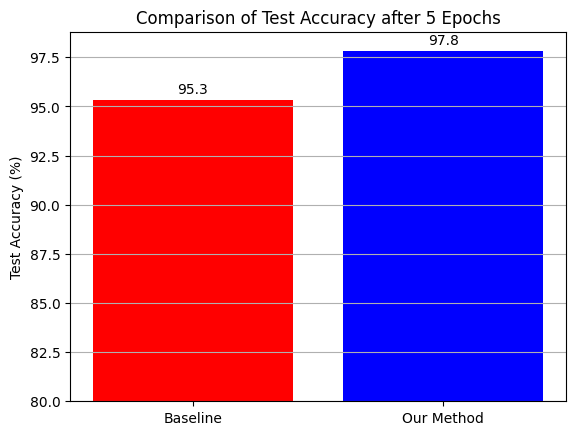

In [ ]:
import matplotlib.pyplot as plt

methods = ['Baseline', 'Our Method']
accuracies = [normal_finetuning_accuracy, your_method_accuracy]

plt.bar(methods, accuracies, color=['red', 'blue'])

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.2, str(v), ha='center', va='bottom')

plt.title('Comparison of Test Accuracy after 5 Epochs')
plt.ylabel('Test Accuracy (%)')

plt.ylim(80, max(accuracies) + 1)

plt.grid(axis='y')
plt.show()
